In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91886\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91886\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_aap = pd.read_csv('dataset/AamAadmiParty.csv')
df_bjp = pd.read_csv('dataset/BJP4India.csv')
df_inc = pd.read_csv('dataset/INCIndia.csv')

# Preprocessing and Visualizing

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.replace('\n', ' ')
    text = text.lower()
    text = re.sub(r'\bhttp\w*\b', '', str(text))
    text = text.replace('amp',' ')
    return text

In [4]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text_tokens = text.split()
    filtered_tokens = [token for token in text_tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [5]:
def stem_text(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

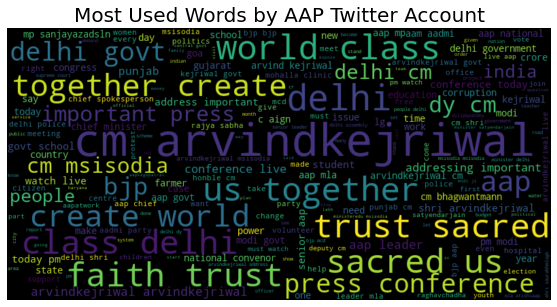

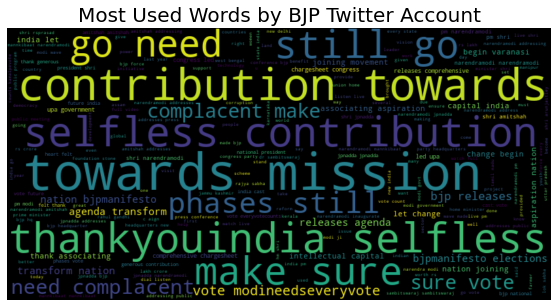

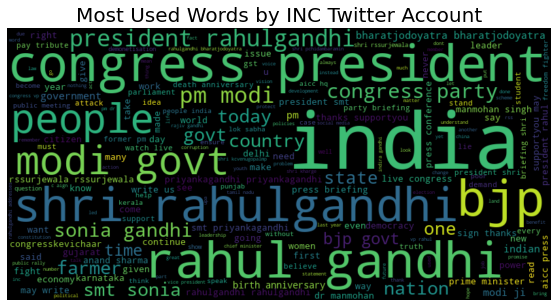

In [6]:
party_names = ['AAP', 'BJP', 'INC']
dfs = [df_aap, df_bjp, df_inc]

for df in dfs:
    df.drop(['Datetime','Tweet Id', 'likeCount'], axis = 1, inplace = True)
    
for party_name, df in zip(party_names, dfs):
    df['Text'] = df['Text'].apply(preprocess_text)
    df['Text'] = df['Text'].apply(remove_stopwords)

    text = ' '.join(df['Text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Used Words by {party_name} Twitter Account', fontsize=20)
    plt.axis('off')
    plt.show()

    df['Text'] = df['Text'].apply(stem_text)

In [7]:
df = pd.concat([df_aap, df_bjp, df_inc], axis=0)
df = df.reset_index(drop=True)
df.dropna(inplace = True)

In [8]:
df.head()

,Text,Username
0,mcd teacher iim train,AamAadmiParty
1,vs win,AamAadmiParty
2,ev delhi electr vehicl,AamAadmiParty
3,adani airport sea port coal bjp modi crore aap...,AamAadmiParty
4,worldclass school kejriw possibl,AamAadmiParty


In [9]:
df.shape

(397438, 2)

In [10]:
df.tail()

,Text,Username
397440,everi th rural household india benefit mnrega ...,INCIndia
397441,india free hunger sardar vallabhbhai patel one...,INCIndia
397442,increas per capita incom india seen unpreced e...,INCIndia
397443,india first alway indian nation congress india...,INCIndia
397444,congress presid write pm express concern ia of...,INCIndia


In [11]:
X = df['Text'].values
y = df['Username'].values

# Tokenisation and Label Encoding

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [13]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [15]:
X

array([[   0,    0,    0, ...,  451, 2367,  496],
       [   0,    0,    0, ...,    0, 1140,  392],
       [   0,    0,    0, ...,   28,  444, 1257],
       ...,
       [   0,    0,    0, ...,  295,   55,   65],
       [   0,    0,    0, ...,  113, 1559, 2718],
       [   0,    0,    0, ..., 1155,  670,  194]])

In [16]:
y

array([0, 0, 0, ..., 2, 2, 2])

0: Aam Aadmi Party, 
1: BJP, 
2: INC

In [17]:
np.unique(y) 

array([0, 1, 2])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an LSTM RNN Model

In [19]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
import os
import tensorflow as tf
checkpoint_dir = 'results/'
os.makedirs(checkpoint_dir,exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir,"mode_epoch_{epoch}.h5"),
                                                        save_weights_only=True,
                                                        monitor='val_loss',
                                                        verbose = 1,
                                                        mode = 'min')

In [23]:
log_csv = tf.keras.callbacks.CSVLogger('results/results.csv',separator=',',append=False)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3,verbose=1)

In [24]:
callbacks = [checkpoint_callback,log_csv,early_stopping_callback]

In [27]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/5
4968/4968 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9310
Epoch 1: saving model to results\mode_epoch_1.h5
4968/4968 [==============================] - 2253s 454ms/step - loss: 0.1707 - accuracy: 0.9310 - val_loss: 0.1394 - val_accuracy: 0.9431
Epoch 2/5
4968/4968 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9505
Epoch 2: saving model to results\mode_epoch_2.h5
4968/4968 [==============================] - 2245s 452ms/step - loss: 0.1181 - accuracy: 0.9505 - val_loss: 0.1398 - val_accuracy: 0.9443
Epoch 3/5
4968/4968 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9560
Epoch 3: saving model to results\mode_epoch_3.h5
4968/4968 [==============================] - 2241s 451ms/step - loss: 0.1010 - accuracy: 0.9560 - val_loss: 0.1422 - val_accuracy: 0.9438
Epoch 4/5
4968/4968 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9595
Epoch 4: saving model to results\mode_epoch_4.h5
49

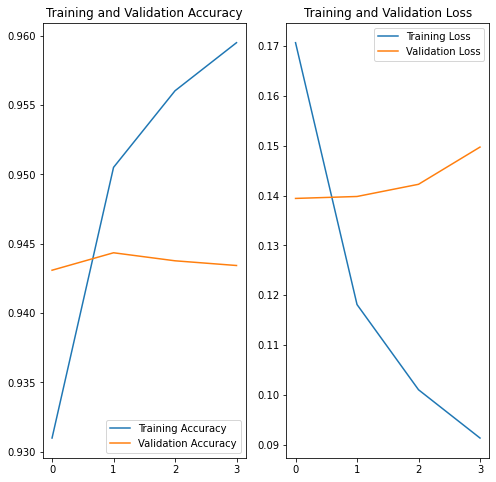

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction Function

In [30]:
def predict_party(tweet):
    processed_text = preprocess_text(tweet)
    text_without_stopwords = remove_stopwords(processed_text)
    stemmed_text = stem_text(text_without_stopwords)
    
    encoded_text = tokenizer.texts_to_sequences([stemmed_text])
    padded_text = pad_sequences(encoded_text, maxlen=X.shape[1])
    
    prediction = model.predict(padded_text)
    predicted_party = label_encoder.inverse_transform([np.argmax(prediction)])
    
    return predicted_party[0]

In [54]:
test_text = ["Mallikarjun Kharge","Nayi Soch Nayi Umeed","Delhi Schools are Transformed"]
for i in test_text:
    predicted_party = predict_party(i)
    print(f"The predicted party Username for Tweet '{i}' is: {predicted_party}")

1/1 [==============================] - 0s 48ms/step
The predicted party Username for Tweet 'Mallikarjun Kharge' is: INCIndia
1/1 [==============================] - 0s 38ms/step
The predicted party Username for Tweet 'Nayi Soch Nayi Umeed' is: BJP4India
1/1 [==============================] - 0s 37ms/step
The predicted party Username for Tweet 'Delhi Schools are Transformed' is: AamAadmiParty


In [55]:
model.save('model.h5')

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)